## 1. Problem Statement

* Company: "StreamFlix" - A subscription-based streaming service
* Challenge: Losing 15% of customers every month (high churn rate)
* Cost: Each lost customer = $500 in lifetime value
* Your Mission: Build a production ML system to predict which customers will cancel next month

## 2. Data and Libraries Load
### Libraries load



In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math
import warnings
from imblearn.combine import SMOTEENN
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
warnings.filterwarnings("ignore")

%matplotlib inline

### Data load

In [65]:
data_df = pd.read_csv('/Users/hypernova/Public/Akash Stuff/Stream_Flix/StreamFlix_Churn_Analysis/data/raw/Customer-Churn.csv')

### Top 5 Rows

In [66]:
data_df.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


### Shape of the dataset

In [67]:
data_df.shape

(7043, 21)

### Summary of the dataset

In [68]:
data_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [69]:
data_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

### Exploring data

#####  - Found 11 rows where total charges were blank. Hence, removing them

In [70]:
len(data_df[data_df['TotalCharges'] == " "])

11

In [71]:
data_df = data_df[data_df['TotalCharges'] != " "]

### Data transformation - Converting SeniorCitizen to categorical

In [72]:
data_df['SeniorCitizen'] = data_df['SeniorCitizen'].replace({0:'No',1:'Yes'})

### Data transformation - Converting TotalCharges to float

In [73]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'])

### Categorical and Numerical Features

In [74]:
categorical_cols = [cols for cols in data_df.columns if data_df[cols].dtype != 'float' and (cols != 'customerID' and cols != 'tenure')]
numercial_cols = [cols for cols in data_df.columns if data_df[cols].dtype == 'float' or data_df[cols].dtype == 'int64']

In [75]:
#proportion of count data on categorical columns

for col in categorical_cols:
    print(f"------------------{col} proportion-----------------")
    print(data_df[col].value_counts(normalize=True)*100)

------------------gender proportion-----------------
gender
Male      50.469283
Female    49.530717
Name: proportion, dtype: float64
------------------SeniorCitizen proportion-----------------
SeniorCitizen
No     83.759954
Yes    16.240046
Name: proportion, dtype: float64
------------------Partner proportion-----------------
Partner
No     51.749147
Yes    48.250853
Name: proportion, dtype: float64
------------------Dependents proportion-----------------
Dependents
No     70.150739
Yes    29.849261
Name: proportion, dtype: float64
------------------PhoneService proportion-----------------
PhoneService
Yes    90.32992
No      9.67008
Name: proportion, dtype: float64
------------------MultipleLines proportion-----------------
MultipleLines
No                  48.137088
Yes                 42.192833
No phone service     9.670080
Name: proportion, dtype: float64
------------------InternetService proportion-----------------
InternetService
Fiber optic    44.027304
DSL            34.357224


### Insights

* Senior citizens are 17% of total population

* 74% don't have any partner

* Gender proportion has higher males

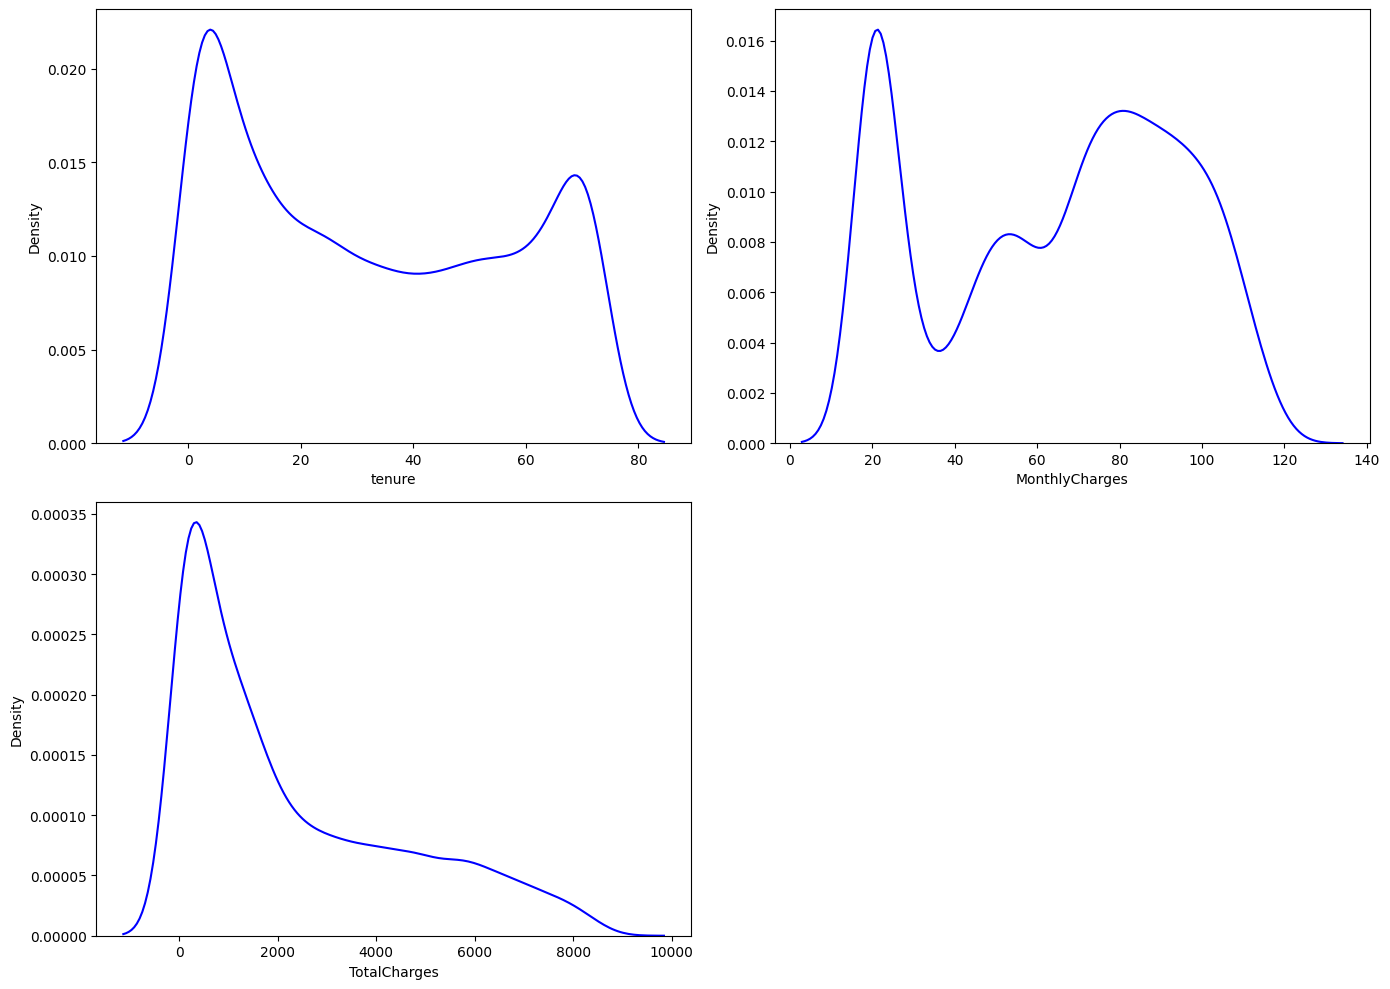

In [76]:
plt.figure(figsize = (14,10))

for i in range(0, len(numercial_cols)):
    plt.subplot(2,2,i+1)
    sns.kdeplot(x = data_df[numercial_cols[i]],color='blue')
    plt.xlabel(numercial_cols[i])
    plt.tight_layout()


### Insights


* Monthly Charges show bimodal distribution

* TotalCharges are skewed towards right

6


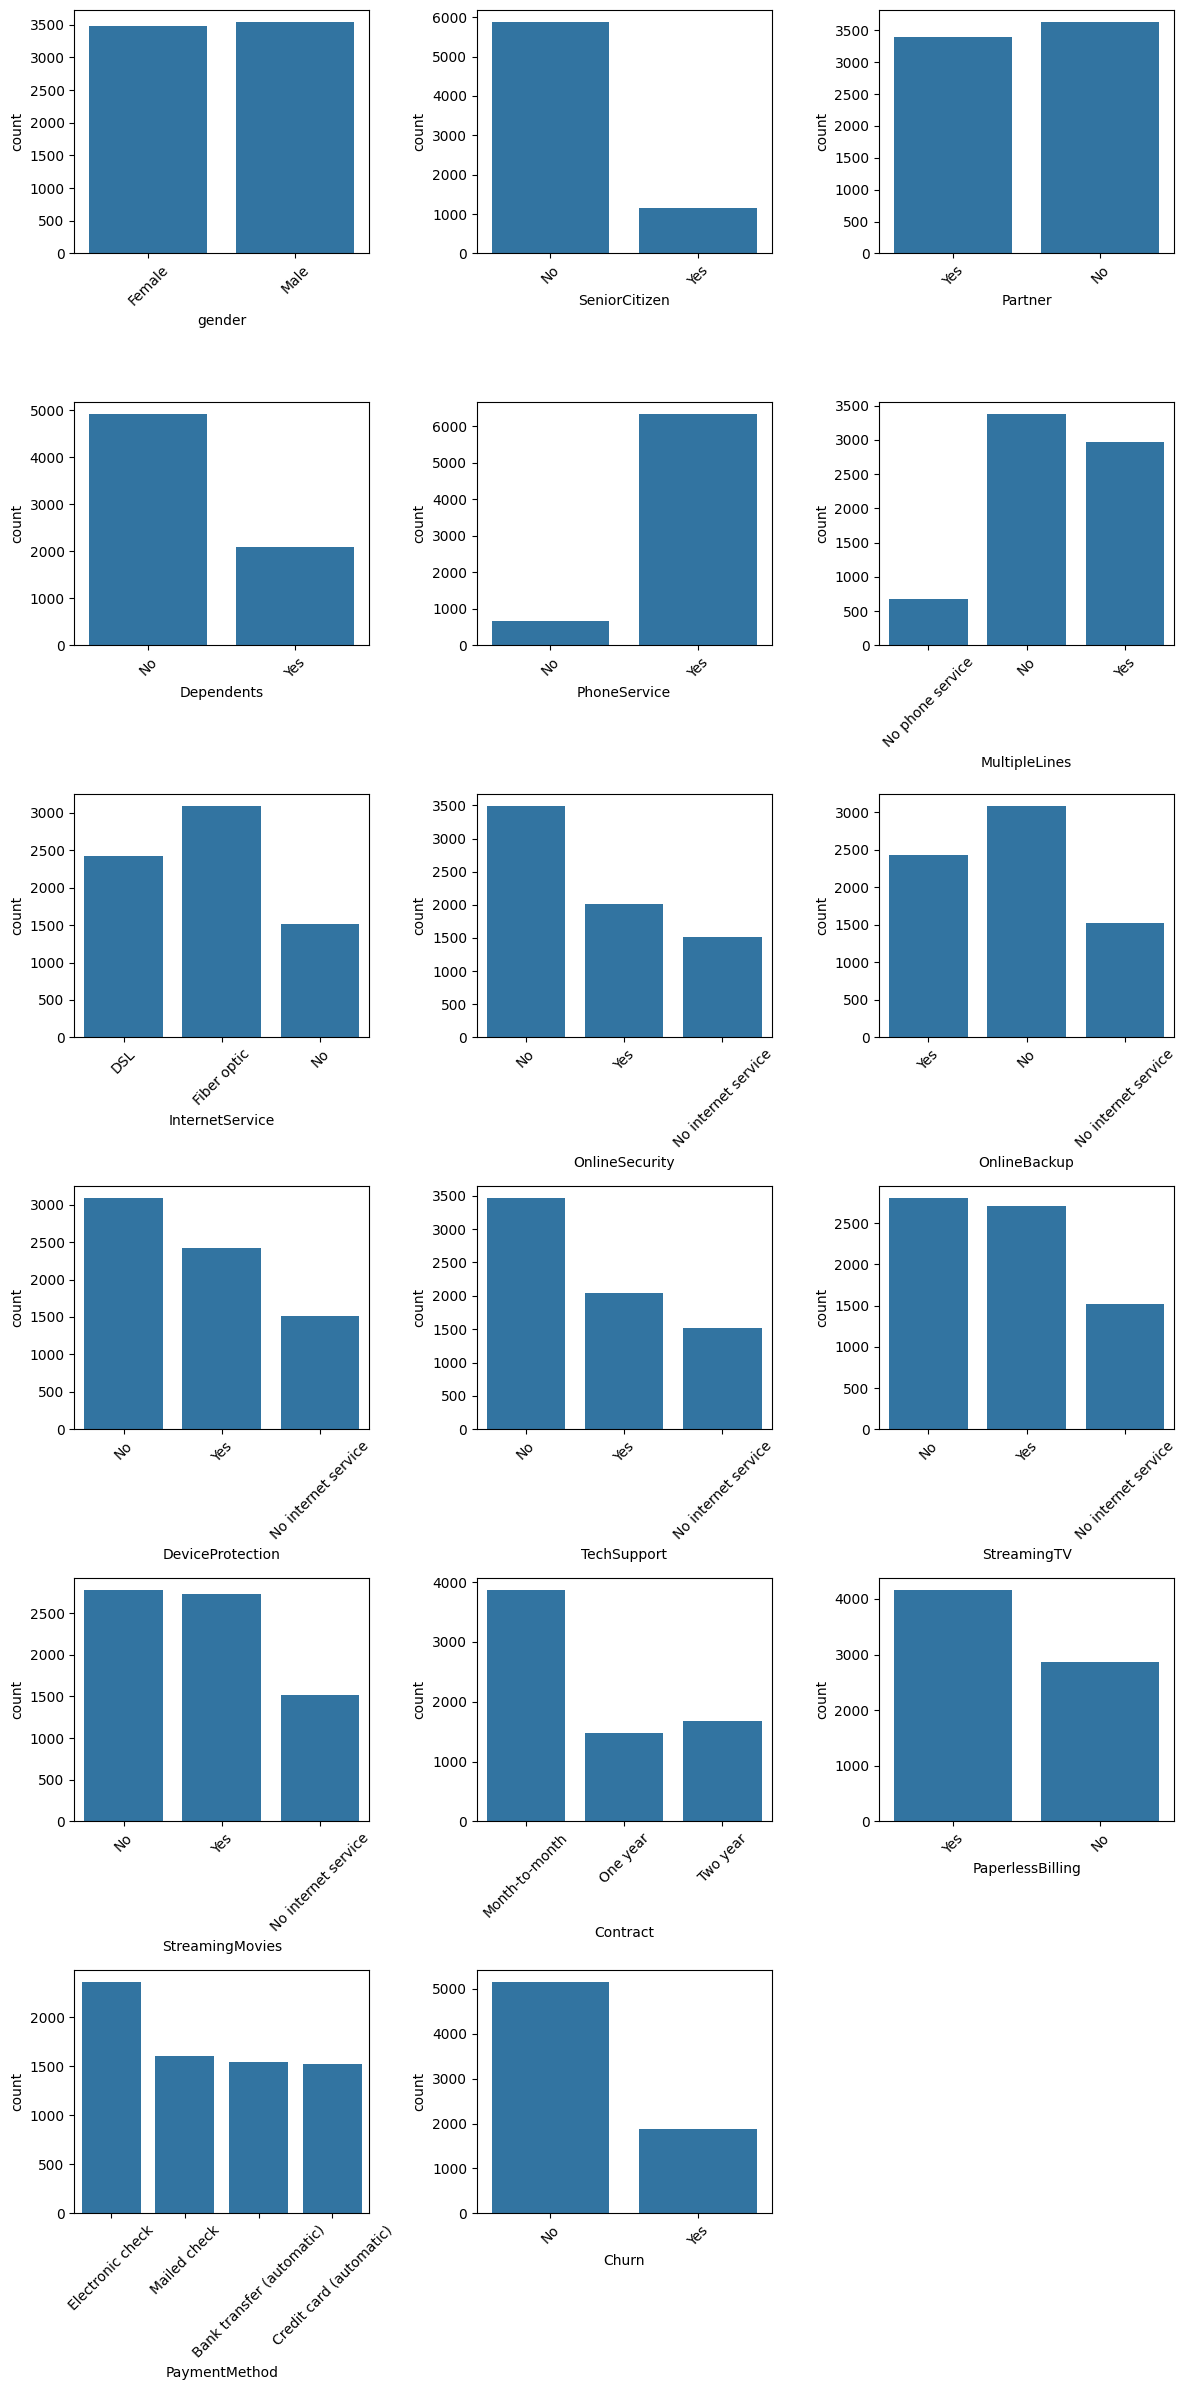

In [77]:
plt.figure(figsize = (12,24))

rows = math.ceil(len(categorical_cols)/3)

print(rows)

for i in range(0,len(categorical_cols)):
    plt.subplot(rows,3,i+1)
    sns.countplot(x = data_df[categorical_cols[i]])
    plt.xticks(rotation=45)
    
plt.tight_layout()

### Insights

* Month to month customers churn more as compared to year plans

* Paperless billing customers churn more as compared to other.

### Chi square test for multicollinearity ( categorical variables)

In [78]:
for cols in categorical_cols:
    if (chi2_contingency(pd.crosstab(data_df['Churn'],data_df[col]))[1]) <=0.05:
        print(f"For Col {cols}, reject null hypothesis -> Significant ")
    else:
        print(f"For Col {cols}, fail to reject null hypothesis -> Not significant ")

For Col gender, reject null hypothesis -> Significant 
For Col SeniorCitizen, reject null hypothesis -> Significant 
For Col Partner, reject null hypothesis -> Significant 
For Col Dependents, reject null hypothesis -> Significant 
For Col PhoneService, reject null hypothesis -> Significant 
For Col MultipleLines, reject null hypothesis -> Significant 
For Col InternetService, reject null hypothesis -> Significant 
For Col OnlineSecurity, reject null hypothesis -> Significant 
For Col OnlineBackup, reject null hypothesis -> Significant 
For Col DeviceProtection, reject null hypothesis -> Significant 
For Col TechSupport, reject null hypothesis -> Significant 
For Col StreamingTV, reject null hypothesis -> Significant 
For Col StreamingMovies, reject null hypothesis -> Significant 
For Col Contract, reject null hypothesis -> Significant 
For Col PaperlessBilling, reject null hypothesis -> Significant 
For Col PaymentMethod, reject null hypothesis -> Significant 
For Col Churn, reject nu

#### Target Variable Analysis

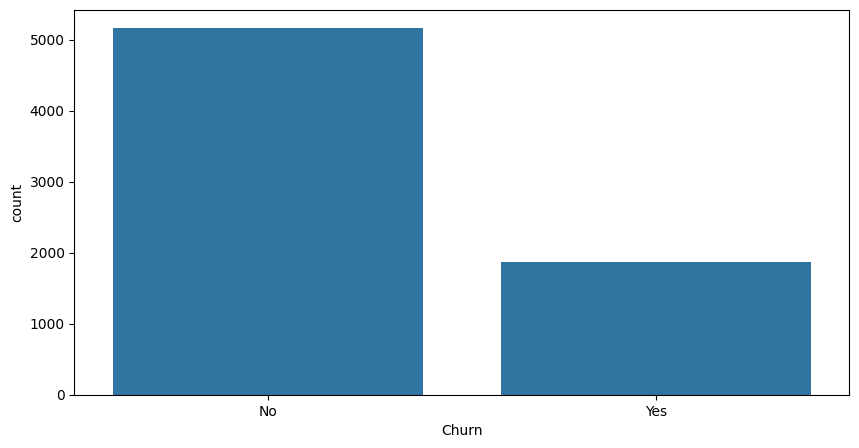

In [79]:
plt.figure(figsize=(10,5))
sns.countplot(data = data_df, x='Churn')
plt.show()

### Insight

target variable has imbalanced data

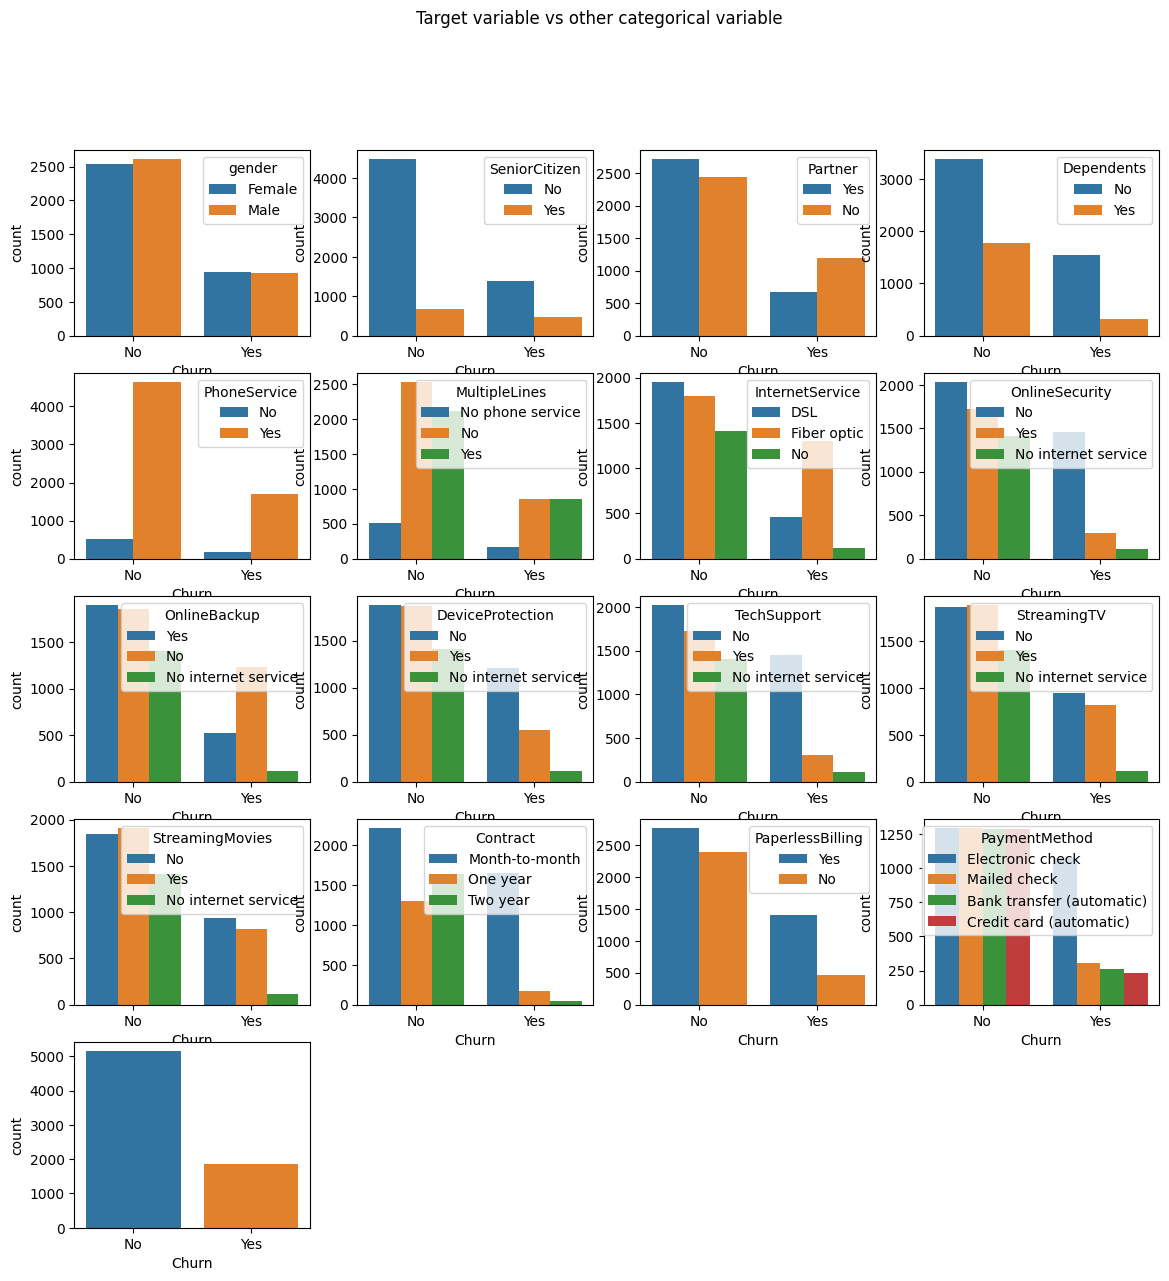

In [80]:
plt.figure(figsize=(14,14))

plt.suptitle("Target variable vs other categorical variable")

rows = math.ceil(len(categorical_cols)/4)

for i in range(0, len(categorical_cols)):
    plt.subplot(rows,4,i+1)
    sns.countplot(data = data_df, x = 'Churn', hue = categorical_cols[i])

### Checking for duplicates

In [81]:
data_df.duplicated().sum()

np.int64(0)

## 3. Feature Generations

In [82]:
X = data_df.drop(['customerID','Churn'], axis = 1)
y = data_df['Churn']

In [83]:
y = np.where(y=='Yes',1,0)

In [84]:
y

array([0, 0, 1, ..., 0, 1, 0], shape=(7032,))

### Feature Transformation

['tenure', 'MonthlyCharges', 'TotalCharges']


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

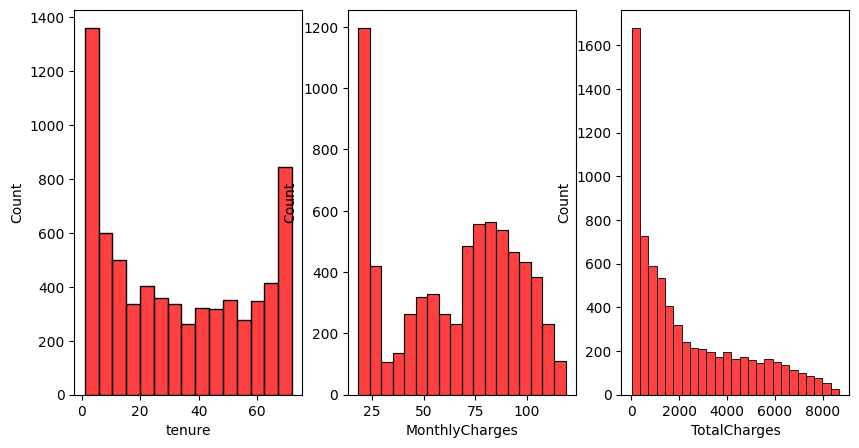

In [85]:
plt.figure(figsize = (10,5))

print(numercial_cols)

for i in range(0 , len(numercial_cols)):
    plt.subplot(1,3,i+1)
    sns.histplot(data = X, x = X[numercial_cols[i]], color='red')
    
plt.tight_layout


In [86]:
# Check Skewness
X[numercial_cols].skew(axis=0, skipna=True)

tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64

### Two vs Multiples classes categorical variables


In [87]:
binary_class_var = [cols for cols in X.columns if X[cols].nunique() ==2 and ((X[cols].dtype != 'float') and (X[cols].dtype != 'int'))]
multi_class_var = [cols for cols in X.columns if X[cols].nunique() >2 and ((X[cols].dtype != 'float') and (X[cols].dtype != 'int'))]

In [88]:
for cols in binary_class_var:
    X[cols] = X[cols].replace({'No':0,'Yes':1})

In [89]:
X['gender'] = X['gender'].replace({'Male':0,'Female':1})

In [90]:
preprocessor = ColumnTransformer([
    ('onehotencoding',OneHotEncoder(),multi_class_var)
])

In [91]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [92]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,random_state=42, shuffle=True,train_size = 0.8)

In [93]:
models = [LogisticRegression(),RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(),KNeighborsClassifier(),
          DecisionTreeClassifier()]

model_performance = {}

for model in models:

    pipeline = ImbPipeline([
        ('prep' ,preprocessor),
        ('smote', SMOTEENN(random_state=42)),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_pred)

    model_performance[model] = {
        'Accuracy' : round(model_test_accuracy,2),
        'F1 score' :round(model_test_f1,2),
        'Precision' :round(model_test_precision,2),
        'Recall' :round(model_test_recall,2),
        'Roc Auc Score' : round(model_test_rocauc_score,2)
    }



In [94]:
model_performance

{LogisticRegression(): {'Accuracy': 0.72,
  'F1 score': 0.6,
  'Precision': 0.48,
  'Recall': 0.79,
  'Roc Auc Score': 0.74},
 RandomForestClassifier(): {'Accuracy': 0.73,
  'F1 score': 0.58,
  'Precision': 0.49,
  'Recall': 0.71,
  'Roc Auc Score': 0.72},
 AdaBoostClassifier(): {'Accuracy': 0.71,
  'F1 score': 0.6,
  'Precision': 0.48,
  'Recall': 0.79,
  'Roc Auc Score': 0.74},
 GradientBoostingClassifier(): {'Accuracy': 0.74,
  'F1 score': 0.59,
  'Precision': 0.51,
  'Recall': 0.71,
  'Roc Auc Score': 0.73},
 KNeighborsClassifier(): {'Accuracy': 0.71,
  'F1 score': 0.52,
  'Precision': 0.46,
  'Recall': 0.59,
  'Roc Auc Score': 0.67},
 DecisionTreeClassifier(): {'Accuracy': 0.71,
  'F1 score': 0.55,
  'Precision': 0.47,
  'Recall': 0.67,
  'Roc Auc Score': 0.7}}